# Download dataset

In [306]:
!kaggle competitions download -c house-prices-advanced-regression-techniques
import zipfile
with zipfile.ZipFile("house-prices-advanced-regression-techniques.zip","r") as zip_f:
    zip_f.extractall("input")

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


# Important imports


In [353]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
import numpy as np
import pandas as pd

import catboost
import catboost.datasets
import shap
import sklearn.model_selection

import matplotlib.pyplot as plt
# import plotly.express as px
import seaborn as sns

from catboost import CatBoostRegressor, Pool, cv

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.feature_selection import RFECV

# import eli5
# from eli5.sklearn import PermutationImportance

# import hyperopt
from sklearn import preprocessing
from numpy.random import RandomState
from os import listdir

from catboost.eval.catboost_evaluation import *
from catboost.utils import create_cd

# import shap
# # load JS visualization code to notebook
# shap.initjs()

# Load dataset

## Train


In [354]:
train = pd.read_csv("input/train.csv", index_col=0)
min_max_scaler = preprocessing.MinMaxScaler()

# # normalize numeric colimns  with min max sacller
# for col in train.columns[:len(train.columns)-1]:
#     if pd.to_numeric(train[col], errors='coerce').notnull().all():
#         train[col] = min_max_scaler.fit_transform(train[col].values.reshape(-1,1))

train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Test 


In [355]:
test = pd.read_csv("input/test.csv", index_col=0)

# # normalize numeric colimns  with min max sacller
# for col in test.columns[:len(test.columns)-1]:
#     if pd.to_numeric(test[col], errors='coerce').notnull().all():
#         test[col] = min_max_scaler.fit_transform(test[col].values.reshape(-1,1))

test.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# data view 

output columns with a large number of missing values

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

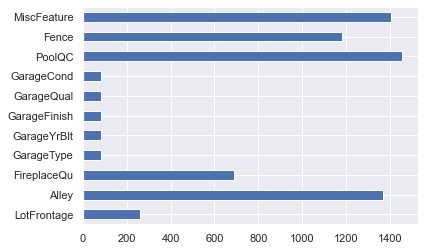

In [356]:
null_features = train.isnull().sum(axis = 0)
null_features[null_features>40].plot(kind = 'barh')
null_features

delete colomns with more then 300 missing values

In [357]:
colomn_to_remove = list(null_features[null_features>300].index)
train.drop(colomn_to_remove, axis=1, inplace=True)
test.drop(colomn_to_remove, axis=1, inplace=True)
print('remove colomn is:')
print(*colomn_to_remove)

remove colomn is:
Alley FireplaceQu PoolQC Fence MiscFeature


### Sale Prise Distribution

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.5, 1.0, 'Target distribution in train')

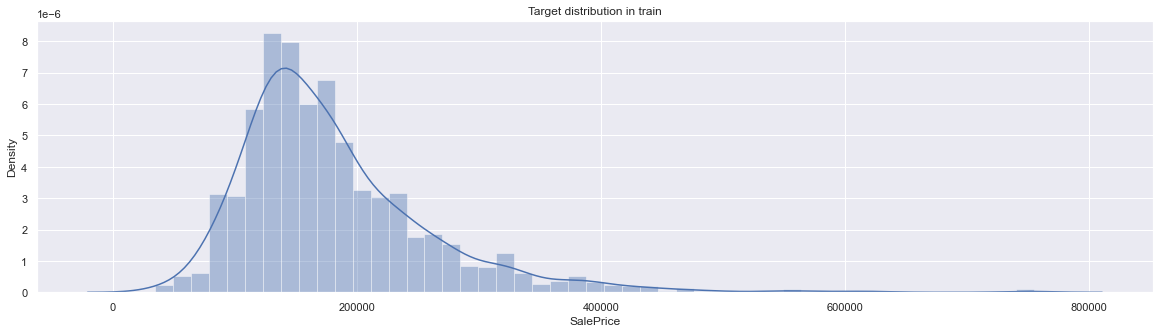

In [358]:
plt.figure(figsize=(20,5))
sns.distplot(train.SalePrice)
plt.title("Target distribution in train")

apply the logarithm function to remove outliers

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.5, 1.0, 'Log distribution in train')

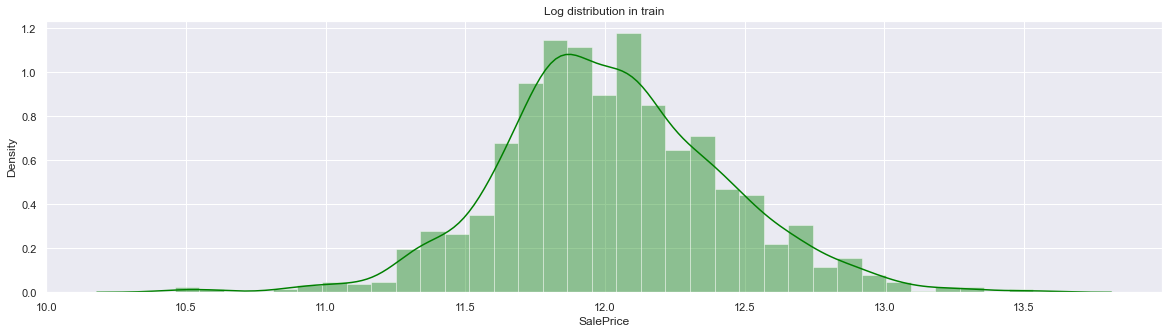

In [359]:
plt.figure(figsize=(20,5))
sns.distplot(np.log(train.SalePrice), color="green")
plt.title("Log distribution in train")

In [360]:
train["SalePrice"] = train.SalePrice.apply(np.log)

In [361]:
num_candidates = list(train.dtypes[train.dtypes!="object"].index.values)
num_candidates

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


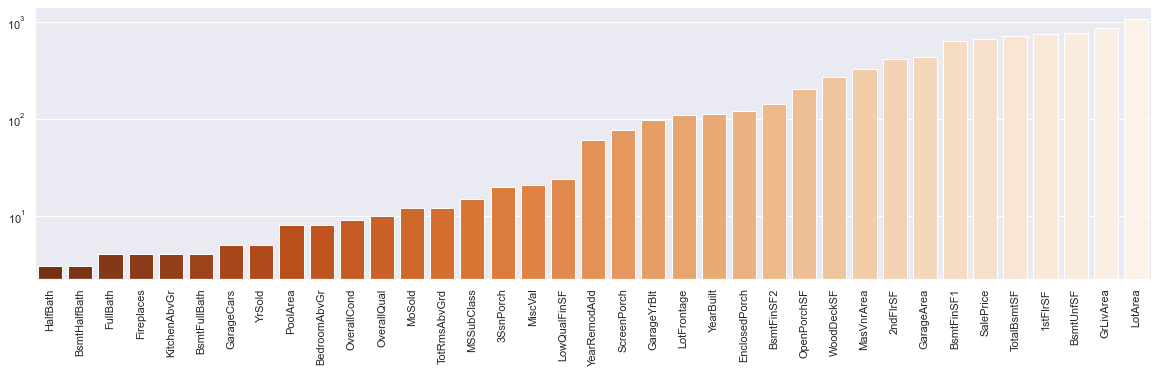

In [362]:
unique_counts = train.loc[:, num_candidates].nunique().sort_values()

plt.figure(figsize=(20,5))
sns.barplot(unique_counts.index, unique_counts.values, palette="Oranges_r")
plt.xticks(rotation=90);
plt.yscale("log")

In [363]:
train['BsmtQual'] = train['BsmtQual'].fillna('No Basement')
train['BsmtCond'] = train['BsmtCond'].fillna('No Basement')
train['BsmtExposure'] = train['BsmtExposure'].fillna('No Basement')
train['BsmtFinType1'] = train['BsmtFinType1'].fillna('No Basement')
train['BsmtFinType2'] = train['BsmtFinType2'].fillna('No Basement')
train['GarageType'] = train['GarageType'].fillna('No Garage')
train['GarageFinish'] = train['GarageFinish'].fillna('No Garage')
train['GarageQual'] = train['GarageQual'].fillna('No Garage')
train['GarageCond'] = train['GarageCond'].fillna('No Garage')

test['BsmtQual'] = test['BsmtQual'].fillna('No Basement')
test['BsmtCond'] = test['BsmtCond'].fillna('No Basement')
test['BsmtExposure'] = test['BsmtExposure'].fillna('No Basement')
test['BsmtFinType1'] = test['BsmtFinType1'].fillna('No Basement')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('No Basement')
test['GarageType'] = test['GarageType'].fillna('No Garage')
test['GarageFinish'] = test['GarageFinish'].fillna('No Garage')
test['GarageQual'] = test['GarageQual'].fillna('No Garage')
test['GarageCond'] = test['GarageCond'].fillna('No Garage')

In [364]:
train['CentralAir'] = [1 if x == train['CentralAir'].unique()[0] else 0 for x in train.loc[:,'CentralAir'].values]
test['CentralAir'] = [1 if x == test['CentralAir'].unique()[0] else 0 for x in test.loc[:,'CentralAir'].values]

In [365]:
cat_features = list(train.select_dtypes(include='object').columns)
train[cat_features].describe().T.sort_values('unique', ascending=False)

,count,unique,top,freq
Neighborhood,1460,25,NAmes,225
Exterior2nd,1460,16,VinylSd,504
Exterior1st,1460,15,VinylSd,515
SaleType,1460,9,WD,1267
Condition1,1460,9,Norm,1260
Condition2,1460,8,Norm,1445
HouseStyle,1460,8,1Story,726
RoofMatl,1460,8,CompShg,1434
BsmtFinType1,1460,7,Unf,430
BsmtFinType2,1460,7,Unf,1256


In [366]:
cat_features = list(train.columns[:len(train.columns)-1])
print(*cat_features)

MSSubClass MSZoning LotFrontage LotArea Street LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle OverallQual OverallCond YearBuilt YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinSF1 BsmtFinType2 BsmtFinSF2 BsmtUnfSF TotalBsmtSF Heating HeatingQC CentralAir Electrical 1stFlrSF 2ndFlrSF LowQualFinSF GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr KitchenQual TotRmsAbvGrd Functional Fireplaces GarageType GarageYrBlt GarageFinish GarageCars GarageArea GarageQual GarageCond PavedDrive WoodDeckSF OpenPorchSF EnclosedPorch 3SsnPorch ScreenPorch PoolArea MiscVal MoSold YrSold SaleType SaleCondition


In [367]:
for feature in cat_features:
    print(f'Feature {feature}')
    display(train[feature].value_counts())
    print('-' * 40)

Feature MSSubClass


20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

----------------------------------------
Feature MSZoning


RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

----------------------------------------
Feature LotFrontage


60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
112.0      1
138.0      1
149.0      1
38.0       1
111.0      1
Name: LotFrontage, Length: 110, dtype: int64

----------------------------------------
Feature LotArea


7200     25
9600     24
6000     17
8400     14
9000     14
         ..
13031     1
10991     1
8944      1
6897      1
8190      1
Name: LotArea, Length: 1073, dtype: int64

----------------------------------------
Feature Street


Pave    1454
Grvl       6
Name: Street, dtype: int64

----------------------------------------
Feature LotShape


Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

----------------------------------------
Feature LandContour


Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

----------------------------------------
Feature Utilities


AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

----------------------------------------
Feature LotConfig


Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

----------------------------------------
Feature LandSlope


Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

----------------------------------------
Feature Neighborhood


NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

----------------------------------------
Feature Condition1


Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

----------------------------------------
Feature Condition2


Norm      1445
Feedr        6
PosN         2
Artery       2
RRNn         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

----------------------------------------
Feature BldgType


1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

----------------------------------------
Feature HouseStyle


1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

----------------------------------------
Feature OverallQual


5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

----------------------------------------
Feature OverallCond


5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

----------------------------------------
Feature YearBuilt


2006    67
2005    64
2004    54
2007    49
2003    45
        ..
1904     1
1898     1
1893     1
1882     1
2010     1
Name: YearBuilt, Length: 112, dtype: int64

----------------------------------------
Feature YearRemodAdd


1950    178
2006     97
2007     76
2005     73
2004     62
       ... 
2010      6
1983      5
1986      5
1952      5
1951      4
Name: YearRemodAdd, Length: 61, dtype: int64

----------------------------------------
Feature RoofStyle


Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

----------------------------------------
Feature RoofMatl


CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
ClyTile       1
Membran       1
Roll          1
Name: RoofMatl, dtype: int64

----------------------------------------
Feature Exterior1st


VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
CBlock       1
AsphShn      1
ImStucc      1
Name: Exterior1st, dtype: int64

----------------------------------------
Feature Exterior2nd


VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
CBlock       1
Other        1
Name: Exterior2nd, dtype: int64

----------------------------------------
Feature MasVnrType


None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

----------------------------------------
Feature MasVnrArea


0.0      861
108.0      8
72.0       8
180.0      8
16.0       7
        ... 
31.0       1
366.0      1
528.0      1
894.0      1
415.0      1
Name: MasVnrArea, Length: 327, dtype: int64

----------------------------------------
Feature ExterQual


TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

----------------------------------------
Feature ExterCond


TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

----------------------------------------
Feature Foundation


PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

----------------------------------------
Feature BsmtQual


TA             649
Gd             618
Ex             121
No Basement     37
Fa              35
Name: BsmtQual, dtype: int64

----------------------------------------
Feature BsmtCond


TA             1311
Gd               65
Fa               45
No Basement      37
Po                2
Name: BsmtCond, dtype: int64

----------------------------------------
Feature BsmtExposure


No             953
Av             221
Gd             134
Mn             114
No Basement     38
Name: BsmtExposure, dtype: int64

----------------------------------------
Feature BsmtFinType1


Unf            430
GLQ            418
ALQ            220
BLQ            148
Rec            133
LwQ             74
No Basement     37
Name: BsmtFinType1, dtype: int64

----------------------------------------
Feature BsmtFinSF1


0       467
24       12
16        9
20        5
686       5
       ... 
535       1
534       1
532       1
522       1
2096      1
Name: BsmtFinSF1, Length: 637, dtype: int64

----------------------------------------
Feature BsmtFinType2


Unf            1256
Rec              54
LwQ              46
No Basement      38
BLQ              33
ALQ              19
GLQ              14
Name: BsmtFinType2, dtype: int64

----------------------------------------
Feature BsmtFinSF2


0       1293
180        5
374        3
117        2
391        2
        ... 
215        1
211        1
210        1
208        1
1474       1
Name: BsmtFinSF2, Length: 144, dtype: int64

----------------------------------------
Feature BsmtUnfSF


0       118
728       9
384       8
572       7
600       7
       ... 
549       1
548       1
545       1
543       1
2046      1
Name: BsmtUnfSF, Length: 780, dtype: int64

----------------------------------------
Feature TotalBsmtSF


0       37
864     35
672     17
912     15
1040    14
        ..
1210     1
727      1
1205     1
1203     1
2046     1
Name: TotalBsmtSF, Length: 721, dtype: int64

----------------------------------------
Feature Heating


GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

----------------------------------------
Feature HeatingQC


Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

----------------------------------------
Feature CentralAir


1    1365
0      95
Name: CentralAir, dtype: int64

----------------------------------------
Feature Electrical


SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

----------------------------------------
Feature 1stFlrSF


864     25
1040    16
912     14
848     12
894     12
        ..
1061     1
1058     1
1051     1
1047     1
2046     1
Name: 1stFlrSF, Length: 753, dtype: int64

----------------------------------------
Feature 2ndFlrSF


0       829
728      10
504       9
672       8
546       8
       ... 
812       1
811       1
473       1
475       1
1872      1
Name: 2ndFlrSF, Length: 417, dtype: int64

----------------------------------------
Feature LowQualFinSF


0      1434
80        3
360       2
392       1
528       1
515       1
514       1
513       1
481       1
479       1
473       1
420       1
397       1
390       1
53        1
384       1
371       1
234       1
232       1
205       1
156       1
144       1
120       1
572       1
Name: LowQualFinSF, dtype: int64

----------------------------------------
Feature GrLivArea


864     22
1040    14
894     11
848     10
1456    10
        ..
2792     1
2794     1
1349     1
1347     1
2054     1
Name: GrLivArea, Length: 861, dtype: int64

----------------------------------------
Feature BsmtFullBath


0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

----------------------------------------
Feature BsmtHalfBath


0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

----------------------------------------
Feature FullBath


2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64

----------------------------------------
Feature HalfBath


0    913
1    535
2     12
Name: HalfBath, dtype: int64

----------------------------------------
Feature BedroomAbvGr


3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

----------------------------------------
Feature KitchenAbvGr


1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

----------------------------------------
Feature KitchenQual


TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

----------------------------------------
Feature TotRmsAbvGrd


6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
2       1
14      1
Name: TotRmsAbvGrd, dtype: int64

----------------------------------------
Feature Functional


Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

----------------------------------------
Feature Fireplaces


0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

----------------------------------------
Feature GarageType


Attchd       870
Detchd       387
BuiltIn       88
No Garage     81
Basment       19
CarPort        9
2Types         6
Name: GarageType, dtype: int64

----------------------------------------
Feature GarageYrBlt


2005.0    65
2006.0    59
2004.0    53
2003.0    50
2007.0    49
          ..
1906.0     1
1908.0     1
1933.0     1
1900.0     1
1927.0     1
Name: GarageYrBlt, Length: 97, dtype: int64

----------------------------------------
Feature GarageFinish


Unf          605
RFn          422
Fin          352
No Garage     81
Name: GarageFinish, dtype: int64

----------------------------------------
Feature GarageCars


2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

----------------------------------------
Feature GarageArea


0       81
440     49
576     47
240     38
484     34
        ..
671      1
342      1
673      1
675      1
1418     1
Name: GarageArea, Length: 441, dtype: int64

----------------------------------------
Feature GarageQual


TA           1311
No Garage      81
Fa             48
Gd             14
Ex              3
Po              3
Name: GarageQual, dtype: int64

----------------------------------------
Feature GarageCond


TA           1326
No Garage      81
Fa             35
Gd              9
Po              7
Ex              2
Name: GarageCond, dtype: int64

----------------------------------------
Feature PavedDrive


Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

----------------------------------------
Feature WoodDeckSF


0      761
192     38
100     36
144     33
120     31
      ... 
103      1
269      1
98       1
97       1
857      1
Name: WoodDeckSF, Length: 274, dtype: int64

----------------------------------------
Feature OpenPorchSF


0      656
36      29
48      22
20      21
45      19
      ... 
141      1
137      1
135      1
134      1
547      1
Name: OpenPorchSF, Length: 202, dtype: int64

----------------------------------------
Feature EnclosedPorch


0      1252
112      15
96        6
120       5
192       5
       ... 
170       1
169       1
67        1
68        1
552       1
Name: EnclosedPorch, Length: 120, dtype: int64

----------------------------------------
Feature 3SsnPorch


0      1436
168       3
216       2
144       2
180       2
407       1
320       1
304       1
290       1
245       1
238       1
182       1
196       1
23        1
162       1
153       1
140       1
130       1
96        1
508       1
Name: 3SsnPorch, dtype: int64

----------------------------------------
Feature ScreenPorch


0      1344
192       6
120       5
224       5
180       4
       ... 
175       1
178       1
40        1
185       1
480       1
Name: ScreenPorch, Length: 76, dtype: int64

----------------------------------------
Feature PoolArea


0      1453
480       1
512       1
519       1
555       1
576       1
648       1
738       1
Name: PoolArea, dtype: int64

----------------------------------------
Feature MiscVal


0        1408
400        11
500         8
700         5
450         4
600         4
2000        4
480         2
1200        2
2500        1
350         1
560         1
54          1
620         1
8300        1
800         1
1150        1
15500       1
1300        1
1400        1
3500        1
Name: MiscVal, dtype: int64

----------------------------------------
Feature MoSold


6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

----------------------------------------
Feature YrSold


2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

----------------------------------------
Feature SaleType


WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

----------------------------------------
Feature SaleCondition


Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

----------------------------------------


In [368]:
train_df_no_missing = train.fillna('n/a')

train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    train_df_no_missing.drop(columns=['SalePrice']),
    train_df_no_missing['SalePrice'],
    test_size=0.20,
    # stratify=train_df_no_missing['SalePrice'],
    random_state=2021
)

In [369]:
for col in cat_features:
    train_X[col] = train_X[col].astype(str)
    val_X[col] = val_X[col].astype(str)


In [370]:
train_pool = catboost.Pool(
    data = train_X,
    label = train_y,
    cat_features=cat_features
)
val_pool = catboost.Pool(
    data = val_X,
    label = val_y,
    cat_features=cat_features
)
# test_pool = catboost.Pool(
#     test_X,
#     # label=test_y,
#     cat_features=cat_features
# )

In [384]:
catboost_train_dir = 'catboost_clf_on_adult'
clf = catboost.CatBoostRegressor(loss_function='RMSE', 
                                 random_seed=2021, 
                                 max_depth = 15,
                                 learning_rate = 1,
                                 random_strength=1,
                                 max_ctr_complexity=1,
                                 l2_leaf_reg=8,
                                 grow_policy = 'Lossguide',
                                 task_type='GPU')
clf.fit(train_pool, eval_set=val_pool)

maining: 1.63s
776:	learn: 0.0002418	test: 0.1924056	best: 0.1734991 (12)	total: 5.64s	remaining: 1.62s
777:	learn: 0.0002401	test: 0.1924066	best: 0.1734991 (12)	total: 5.65s	remaining: 1.61s
778:	learn: 0.0002370	test: 0.1924048	best: 0.1734991 (12)	total: 5.66s	remaining: 1.6s
779:	learn: 0.0002349	test: 0.1924044	best: 0.1734991 (12)	total: 5.66s	remaining: 1.6s
780:	learn: 0.0002336	test: 0.1924045	best: 0.1734991 (12)	total: 5.67s	remaining: 1.59s
781:	learn: 0.0002323	test: 0.1924047	best: 0.1734991 (12)	total: 5.68s	remaining: 1.58s
782:	learn: 0.0002308	test: 0.1924045	best: 0.1734991 (12)	total: 5.68s	remaining: 1.57s
783:	learn: 0.0002288	test: 0.1924044	best: 0.1734991 (12)	total: 5.69s	remaining: 1.57s
784:	learn: 0.0002279	test: 0.1924045	best: 0.1734991 (12)	total: 5.69s	remaining: 1.56s
785:	learn: 0.0002269	test: 0.1924032	best: 0.1734991 (12)	total: 5.7s	remaining: 1.55s
786:	learn: 0.0002256	test: 0.1924047	best: 0.1734991 (12)	total: 5.71s	remaining: 1.54s
787:	lear

In [385]:
test_metrics = clf.eval_metrics(
    val_pool,
    metrics=['RMSE'],
    ntree_start=clf.best_iteration_ - 1,
    ntree_end=clf.best_iteration_,
    eval_period=1,
    thread_count=-1
)

In [386]:
test_metrics

{'RMSE': [0.17412475868945915]}

Processing trees...
13/13 trees processed	passed time: 172us	remaining time: 0us
Processing documents...
128/1168 documents processed	passed time: 8.41ms	remaining time: 68.3ms
1168/1168 documents processed	passed time: 85.5ms	remaining time: 0us


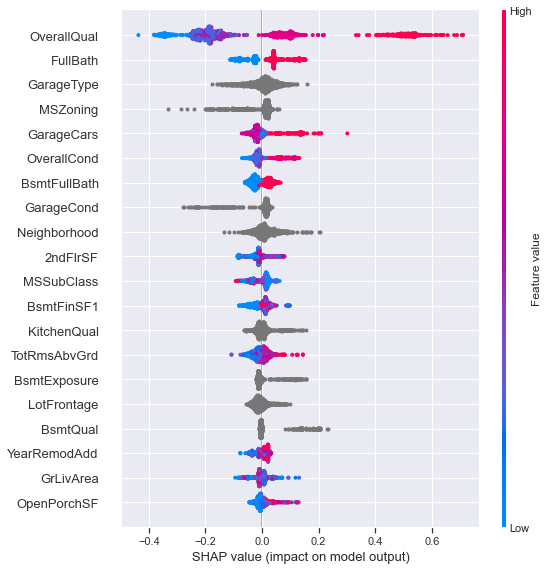

In [387]:
sorted(
    zip(train_X.columns, clf.feature_importances_), 
    key=lambda p: p[1], 
    reverse=True
)

shap_info = clf.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]
shap.summary_plot(shap_values, train_X)

In [388]:
train_X.columns[:12]

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1'],
      dtype='object')

Text(0.5, 0, 'CatBoost Feature Importance')

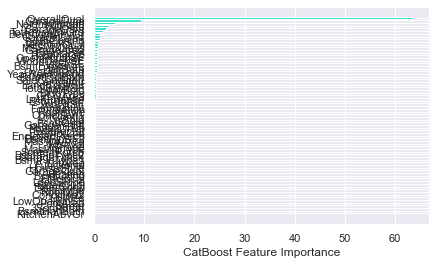

In [389]:
sorted_feature_importance = clf.feature_importances_.argsort()
plt.barh(train_X.columns[sorted_feature_importance],clf.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")


In [390]:
test = test.applymap(str)
pred = clf.predict(test)

In [391]:
submission = pd.DataFrame()
sample_submission = pd.read_csv('input/sample_submission.csv',header = 0)
submission['Id'] = sample_submission.Id
submission['SalePrice'] = np.exp(pred)
submission.to_csv('submission.csv', index=False)
submission.head(5)

,Id,SalePrice
0,1461,126861.954032
1,1462,155930.742982
2,1463,189328.886075
3,1464,206267.834364
4,1465,243487.608150


In [392]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m 'first try'

100%|██████████████████████████████████████| 33.6k/33.6k [00:06<00:00, 5.74kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques